In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [22]:
df_train = pd.read_csv("../data/raw/train.csv")

# Feature Engineering
## Missing Values

In [9]:
#split cabin into three columns: deck num and side
#train set cabin
cabin = df_train['Cabin'].copy()
cabin=pd.DataFrame(cabin.str.split("/"))
cabin_info = cabin.Cabin.apply(pd.Series)
cabin_info.columns = ['Deck','Num','Side']
df_train = pd.concat([df_train,cabin_info],axis=1)
df_train.drop("Cabin",axis=1,inplace=True)

In [10]:
#categorical features missing value handling
def filling_HomePlanet(df):   
    mode = df['HomePlanet'].value_counts().index[0]
    df['HomePlanet'] = df['HomePlanet'].fillna(mode)
    return df

def filling_CryoSleep(df):
    df["CryoSleep"] = df['CryoSleep'].fillna(False)
    return df

def filling_Cabin(df):
    df['Deck'] = df['Deck'].fillna('F')
    mode = df[df.Deck=='F']['Side'].value_counts().index[0]
    df['Side'] =mode
    df['Num'] = df['Num'].astype(float)
    df['Num'] = df['Num'].fillna(1796/2)
    return df

def filling_Destination(df):
    mode = df['Destination'].value_counts().index[0]
    df['Destination'] = df['Destination'].fillna(mode)
    return df

def filling_VIP(df):
    df['VIP'] = df['VIP'].fillna(False)
    return df

def filling_Name(df):
    df['Name'] = df['Name'].fillna('None')
    return df

def filling_categorical(df):
    df = filling_Cabin(df)
    df = filling_CryoSleep(df)
    df = filling_HomePlanet(df)
    df = filling_Destination(df)
    df = filling_Name(df)
    df = filling_VIP(df)
    return df

In [11]:
#Numerical features missing value handling
def filling_Age(df):
    #fill age by median
    median = df['Age'].describe()[5]
    df['Age'] = df['Age'].fillna(median)
    return df

def filling_luxury(df):
    luxury_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    df[luxury_features] = df[luxury_features].fillna(0.0)
    return df

def filling_numerical(df):
    df = filling_Age(df)
    df = filling_luxury(df)
    return df

    

In [12]:
def filling_missing(df):
    df = filling_categorical(df)
    df = filling_numerical(df)
    return df

df_train = filling_missing(df_train)

/var/folders/p_/wj4jvr5929x__hfp1fb3gy400000gs/T/ipykernel_48101/543249872.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["CryoSleep"] = df['CryoSleep'].fillna(False)
/var/folders/p_/wj4jvr5929x__hfp1fb3gy400000gs/T/ipykernel_48101/543249872.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)
/var/folders/p_/wj4jvr5929x__hfp1fb3gy400000gs/T/ipykernel_48101/4180590163.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

In [13]:
na_count = df_train.isna().sum()
na_proportion = na_count/len(df_train)
print(na_count)
print(na_proportion)

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
Num             0
Side            0
dtype: int64
PassengerId     0.0
HomePlanet      0.0
CryoSleep       0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Name            0.0
Transported     0.0
Deck            0.0
Num             0.0
Side            0.0
dtype: float64


In [14]:
#Split luxury facilities cost into groups
df_train['Luxury'] = df_train['VRDeck']+ df_train['ShoppingMall']+df_train['Spa']+df_train['FoodCourt']+df_train['RoomService']
df_train['Luxury']=pd.qcut(df_train['Luxury'],6,duplicates = 'drop')

In [15]:
df_train.drop(['Name','PassengerId'],axis=1,inplace=True)

In [16]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Luxury
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,"(-0.001, 716.0]"
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,P,"(716.0, 979.0]"
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,P,"(2365.0, 35987.0]"
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,P,"(2365.0, 35987.0]"
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,P,"(979.0, 2365.0]"


In [18]:
DEBUG =0
df_numeric= df_train.select_dtypes(include =[np.number])
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.75)))
        print('median = '+str(df_numeric[feature].median()))
        print((df_numeric[feature].max-df_train[feature].quantile(0.75))>(df_train[feature].quantile(0.75)-df_numeric[feature].median()))
        print('----------------------------------------------------')
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
        df_train[feature] = np.where(df_train[feature]<df_train[feature].quantile(0.95), df_train[feature], df_train[feature].quantile(0.95))

In [19]:
df_numeric = df_train.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')
    if df_numeric[feature].nunique()>50:
        if df_numeric[feature].min()==0:
            df_train[feature] = np.log(df_train[feature]+1)
        else:
            df_train[feature] = np.log(df_train[feature])


In [20]:
df_train= pd.get_dummies(df_train,drop_first=True)
df_numeric = df_train.select_dtypes(include = [np.number])
df_cat = df_train.select_dtypes(exclude = [np.number])
X = df_train.drop('Transported',axis=1)
y = df_train['Transported']
feature_names = list(X.columns)
df_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,"Luxury_(716.0, 979.0]","Luxury_(979.0, 2365.0]","Luxury_(2365.0, 35987.0]"
0,False,3.688879,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,...,True,False,False,False,False,False,False,False,False,False
1,False,3.218876,False,4.700480,2.302585,3.258097,6.309918,3.806662,True,0.000000,...,False,False,False,False,True,False,False,True,False,False
2,False,4.077537,True,3.784190,7.889894,0.000000,7.361553,3.912023,False,0.000000,...,False,False,False,False,False,False,False,False,False,True
3,False,3.526361,False,0.000000,7.157735,5.918894,7.361553,5.267858,False,0.000000,...,False,False,False,False,False,False,False,False,False,True
4,False,2.833213,False,5.717028,4.262680,5.023881,6.338594,1.098612,True,0.693147,...,False,False,False,False,True,False,False,False,True,False


In [14]:
le = LabelEncoder()
for i in ['CryoSleep','VIP','Transported']:
    df_train[i] = le.fit_transform(df_train[i])

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score, plot_confusion_matrix,matthews_corrcoef
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','ROC AUC'])

<AxesSubplot:>

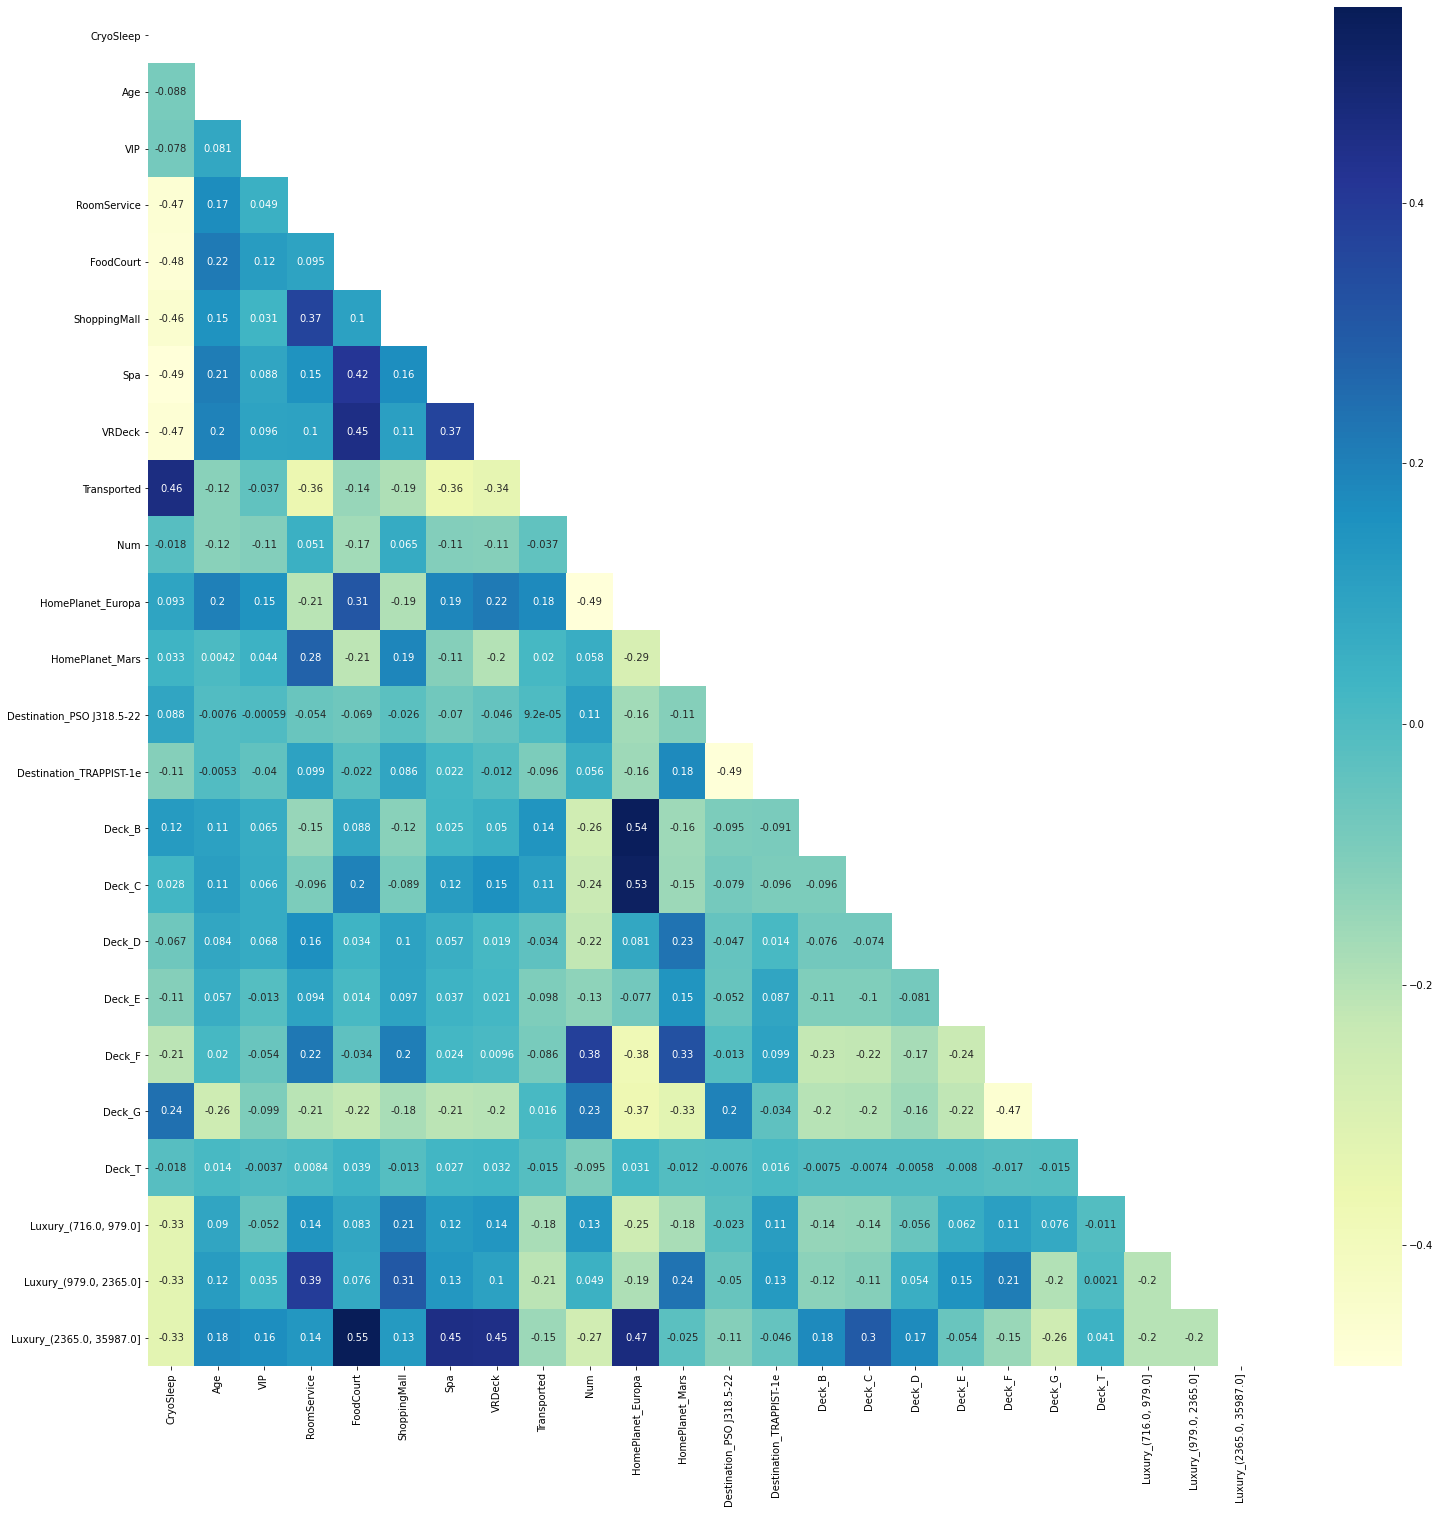

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (25,25))
mask = np.triu(np.ones_like(df_train.corr(),dtype=bool))
sns.heatmap(df_train.corr(),mask=mask,cmap="YlGnBu",annot=True)

# Modeling
1. LDA
2. QDA
3. Logistics
4. KNN
5. Naive Bayes
6. Random Forest
7. Gradient Boosting





In [17]:
train,test = train_test_split(df_train,test_size=0.3)
y_tr = train['Transported']
y_te = test['Transported']
train.drop('Transported',axis=1,inplace=True)
test.drop('Transported',axis=1, inplace = True)
X_tr = train
X_te = test
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_tr = sc.fit_transform(X_tr)
X_te = sc.transform(X_te)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## LDA QDA

In [18]:
lda_model = lda().fit(X_tr,y_tr)
y_te_pred = lda_model.predict(X_te)
print('Validation Error: %.3f' % (1-np.mean(y_te==y_te_pred)))

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['LDA'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]


Validation Error: 0.233
Accuracy: 76.73%
Recall: 76.73%
Precision: 76.73%
F1-Score: 76.73%
MCC: 53.46%
ROC AUC score: 76.73%


In [19]:
accuracy_score(y_tr,lda_model.predict(X_tr))

0.7694330320460148

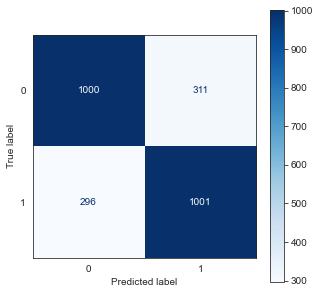

In [20]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(lda_model, X_te, y_te, cmap=plt.cm.Blues)  
plt.show()

In [21]:
#GridSearchCV tuning
model = lda(n_components=1)
solvers = ['lsqr','eigen']
shrinkage = ['auto']
grid = dict(solver = solvers, shrinkage=shrinkage)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=41)
grid_search_lda = GridSearchCV(estimator = model, param_grid=grid, n_jobs=-1, cv=cv,scoring='accuracy')
grid_result_lda = grid_search_lda.fit(X_tr,y_tr)
print("Best: %f using %s" % (grid_result_lda.best_score_, grid_result_lda.best_params_))
solver = grid_result_lda.best_params_['solver']


model_lda = lda(solver = solver,shrinkage='auto',n_components=1).fit(X_tr,y_tr)
y_tr_pred = model_lda.predict(X_tr)
y_te_pred = model_lda.predict(X_te)
print('Mean training error: %.3f' % (np.mean(y_tr_pred!=y_tr)))
print('Mean validation error: %.3f' % (np.mean(y_te_pred!=y_te)))

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, model_lda.predict_proba(X_te)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['LDA_tuning'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Best: 0.767078 using {'shrinkage': 'auto', 'solver': 'lsqr'}
Mean training error: 0.234
Mean validation error: 0.235
Accuracy: 76.53%
Recall: 76.53%
Precision: 76.53%
F1-Score: 76.53%
MCC: 53.07%
ROC AUC score: 84.53%


In [22]:
accuracy_score(y_tr,model_lda.predict(X_tr))

0.7664749383730485

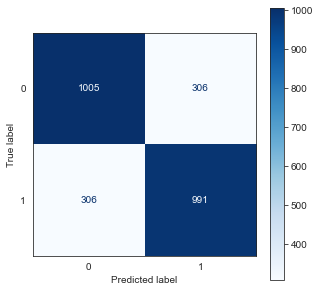

In [23]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model_lda, X_te, y_te, cmap=plt.cm.Blues)  
plt.show()

## Logistic Regression

In [24]:
#Add Penalties
#logistic model
l = LogisticRegressionCV(cv = 10, random_state=41,solver='liblinear',penalty='l1',Cs=10).fit(X_tr,y_tr)
y_tr_pred = l.predict(X_tr)
y_te_pred = l.predict(X_te)
print('Mean training error: %.3f' % (np.mean(y_tr_pred!=y_tr)))
print('Mean validation error: %.3f' % (np.mean(y_te_pred!=y_te)))

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, l.predict_proba(X_te)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Logistic_l1'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Mean training error: 0.232
Mean validation error: 0.232
Accuracy: 76.84%
Recall: 76.84%
Precision: 76.85%
F1-Score: 76.84%
MCC: 53.69%
ROC AUC score: 84.63%


In [25]:
accuracy_score(y_tr,l.predict(X_tr))

0.7684470008216927

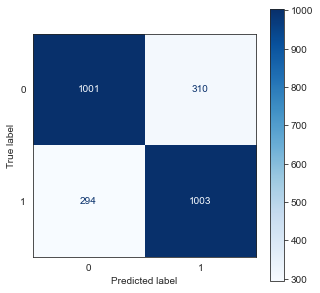

In [26]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(l, X_te,y_te, cmap=plt.cm.Blues)  
plt.show()

In [27]:
#GridSearchCV tuning
model = LogisticRegression()
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l2']
c_values = [1000,100,1.0,0.1,0.01]
grid = dict(solver = solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=41)
grid_search_logis = GridSearchCV(estimator = model, param_grid=grid, n_jobs=-1, cv=cv,scoring='accuracy')
grid_result_logis = grid_search_logis.fit(X_tr,y_tr)
print("Best: %f using %s" % (grid_result_logis.best_score_, grid_result_logis.best_params_))

c = grid_result_logis.best_params_['C']
penalty = grid_result_logis.best_params_['penalty']
solver = grid_result_logis.best_params_['solver']

model_log = LogisticRegression(C=c,penalty=penalty,solver=solver).fit(X_tr,y_tr)
y_tr_pred = model_log.predict(X_tr)
y_te_pred = model_log.predict(X_te)
print('Mean training error: %.3f' % (np.mean(y_tr_pred!=y_tr)))
print('Mean validation error: %.3f' % (np.mean(y_te_pred!=y_te)))

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, model_log.predict_proba(X_te)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Logistic_l2'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Best: 0.766750 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean training error: 0.233
Mean validation error: 0.234
Accuracy: 76.61%
Recall: 76.61%
Precision: 76.61%
F1-Score: 76.61%
MCC: 53.22%
ROC AUC score: 84.51%


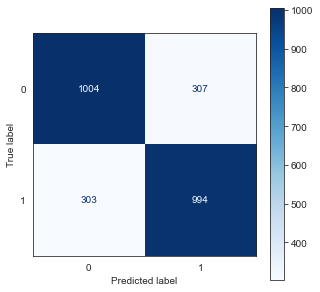

In [28]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model_log, X_te,y_te, cmap=plt.cm.Blues)  
plt.show()

## KNN

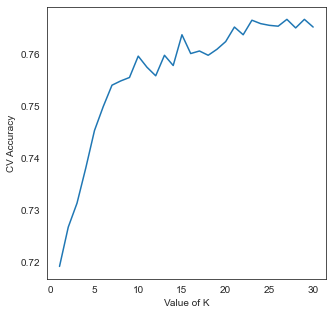

Accuracy: 76.92%
Recall: 76.92%
Precision: 77.33%
F1-Score: 76.82%
MCC: 54.23%
ROC AUC score: 76.88%


In [29]:
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,X_tr,y_tr,cv=10,scoring ='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of K')
plt.ylabel('CV Accuracy')
plt.show()


k = k_scores.index(max(k_scores))
knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr,y_tr)
y_te_pred = knn.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['KNN'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

In [30]:
y_tr_pred = knn.predict(X_tr)
tr_acc = accuracy_score(y_tr,y_tr_pred)
print(tr_acc)

0.7794576828266229


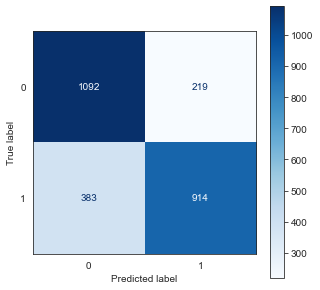

In [31]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(knn, X_te,y_te, cmap=plt.cm.Blues)  
plt.show()

## Decision Tree


In [32]:
tree = DecisionTreeClassifier().fit(X_tr,y_tr)
y_te_pred = tree.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Accuracy: 74.16%
Recall: 74.16%
Precision: 74.17%
F1-Score: 74.16%
MCC: 48.32%
ROC AUC score: 74.16%


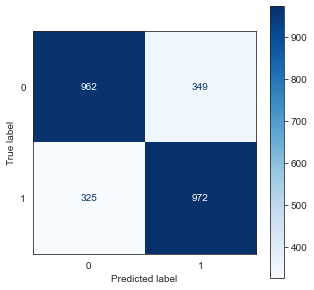

In [33]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(tree, X_te,y_te, cmap=plt.cm.Blues)  
plt.show()

## Random Forest

In [34]:

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=41,bootstrap=True).fit(X_tr,y_tr)
y_te_pred = rf.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Accuracy: 78.45%
Recall: 78.45%
Precision: 78.55%
F1-Score: 78.43%
MCC: 56.99%
ROC AUC score: 78.43%


In [35]:
y_tr_pred = rf.predict(X_tr)
tr_acc = accuracy_score(y_tr,y_tr_pred)
print(tr_acc)

0.9995069843878389


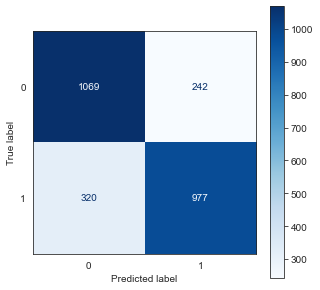

In [36]:
plt.rcParams['figure.figsize']=5,5
sns.set_style("white")
plot_confusion_matrix(rf,X_te,y_te,cmap=plt.cm.Blues)
plt.show()

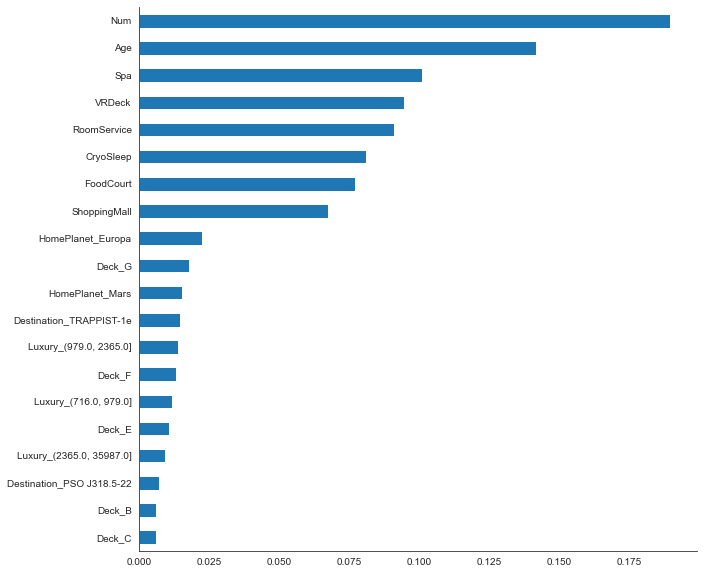

In [37]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(rf.feature_importances_, index=feature_names)
# feat_importances = pd.Series(model.feature_importances_,)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()


In [38]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=41,bootstrap=True).fit(X_tr,y_tr)
y_te_pred = rf.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Accuracy: 78.45%
Recall: 78.45%
Precision: 78.55%
F1-Score: 78.43%
MCC: 56.99%
ROC AUC score: 78.43%


Gradient Boosting


In [39]:
model = GradientBoostingClassifier(n_estimators=200,random_state=41).fit(X_tr,y_tr)
y_te_pred = model.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Gradient Boosting'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Accuracy: 80.21%
Recall: 80.21%
Precision: 80.34%
F1-Score: 80.20%
MCC: 60.56%
ROC AUC score: 80.23%


In [40]:

model_performance.loc['Gradient Boosting'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

In [41]:
accuracy_score(y_tr,model.predict(X_tr))

0.8299096138044372

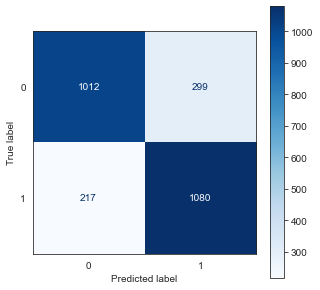

In [42]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_te, y_te, cmap=plt.cm.Blues)  
plt.show()

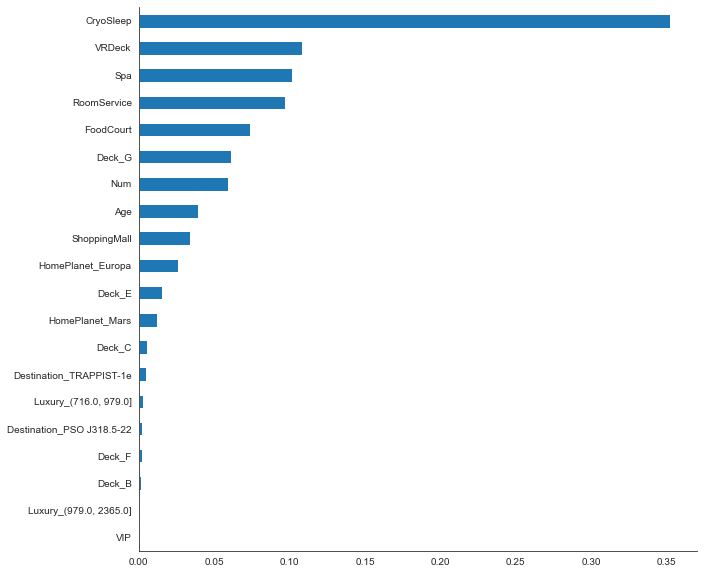

In [43]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
# feat_importances = pd.Series(model.feature_importances_,)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [44]:
model= GaussianNB().fit(X_tr,y_tr)
y_te_pred = model.predict(X_te)

accuracy = accuracy_score(y_te, y_te_pred)
recall = recall_score(y_te, y_te_pred, average='weighted')
precision = precision_score(y_te, y_te_pred, average='weighted')
f1s = f1_score(y_te, y_te_pred, average='weighted')
MCC = matthews_corrcoef(y_te, y_te_pred)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_te, y_te_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))

model_performance.loc['Gaussian Bayes'] = [accuracy, recall, precision, f1s,MCC,ROC_AUC]

Accuracy: 73.85%
Recall: 73.85%
Precision: 74.03%
F1-Score: 73.79%
MCC: 47.87%
ROC AUC score: 73.82%


In [45]:
y_tr_pred=model.predict(X_tr)
accuracy_score(y_tr,y_tr_pred)

0.7442892358258012

In [46]:
model_performance.style.background_gradient(cmap='coolwarm')

,Accuracy,Recall,Precision,F1-Score,MCC score,ROC AUC
LDA,0.767255,0.767255,0.767304,0.767254,0.534560,0.767279
LDA_tuning,0.765337,0.765337,0.765337,0.765337,0.530661,0.845286
Logistic_l1,0.768405,0.768405,0.768461,0.768404,0.536867,0.846326
Logistic_l2,0.766104,0.766104,0.766111,0.766106,0.532205,0.845058
KNN,0.769172,0.769172,0.773345,0.768176,0.542331,0.768828
Decision Tree,0.741564,0.741564,0.741672,0.741555,0.483247,0.741606
Random Forest,0.784509,0.784509,0.785462,0.784282,0.569889,0.784342
Gradient Boosting,0.802147,0.802147,0.803413,0.801985,0.605614,0.802310
Gaussian Bayes,0.738497,0.738497,0.740340,0.737897,0.478691,0.738247
